### Librerías



#Punto 1 - Sinc + noise - cross validation

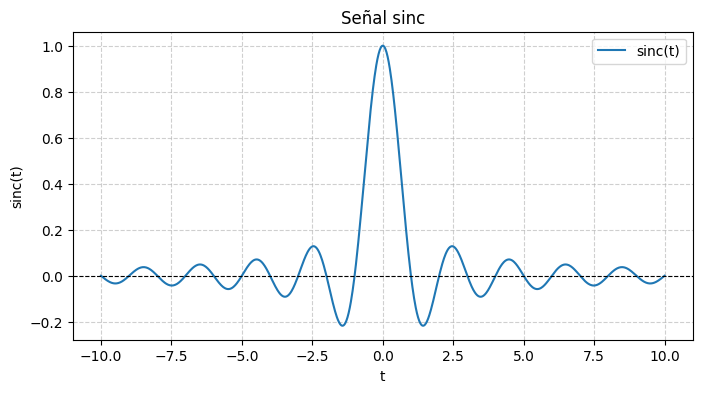

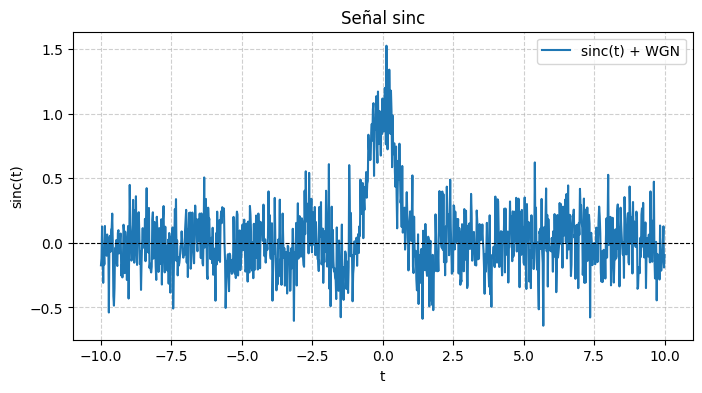

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Rango de tiempo
t = np.linspace(-10, 10, 1000)  # 1000 puntos entre -10 y 10

# Señal sinc
signal = (np.sinc(t))

#ruido blanco gaussiano

def var_snr(x,snrdB): #x vector de datos (señal), snrdB SNR en dB
    Px = np.mean(x**2)#estimador potencia media de la señal
    return Px/(10**(snrdB/10))


# Señal con ruido
snrdB = 1

P_signal = np.mean(signal**2)

# Convertir SNR a lineal
SNR_linear = 10**(snrdB/10)

# Varianza del ruido en función de la SNR
var_ruido = P_signal / SNR_linear


ruido = np.sqrt(var_ruido) * np.random.randn(len(signal))

signal_ruido = signal + ruido

# Graficar
plt.figure(figsize=(8,4))
plt.plot(t, signal, label="sinc(t)")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.title("Señal sinc")
plt.xlabel("t")
plt.ylabel("sinc(t)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


plt.figure(figsize=(8,4))
plt.plot(t, signal_ruido, label="sinc(t) + WGN")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.title("Señal sinc")
plt.xlabel("t")
plt.ylabel("sinc(t)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

MSE promedio (validación cruzada): 0.06870595917141988
MSE test: 0.06070692624238892
R2 test: 0.23076969837291483


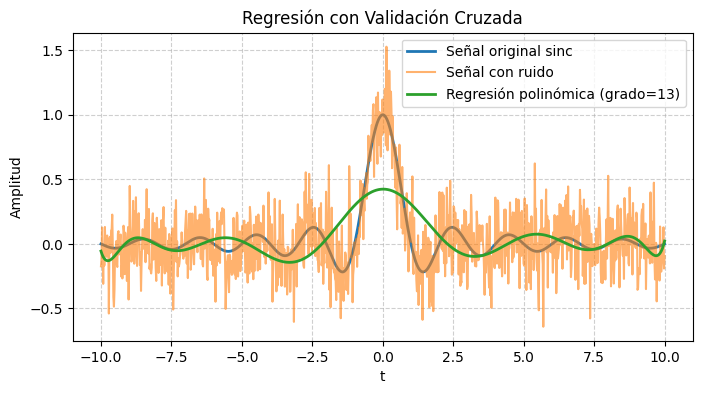

In [13]:
# =====================================================
# REGRESIÓN CON VALIDACIÓN CRUZADA
# =====================================================

# Convertimos el tiempo t en variable independiente (X)
X = t.reshape(-1, 1)   # (1000,1) en vez de (1000,)
y = signal_ruido       # señal con ruido como salida

# Dividir en entrenamiento y prueba (70%-30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Definimos un pipeline: polinomio + regresión lineal
# (puedes probar con grado=5, 10, 15...)
degree = 13
model = Pipeline([
    ("poly", PolynomialFeatures(degree=degree)),
    ("linear", LinearRegression())
])

# Validación cruzada (K-Fold con 5 particiones)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=kfold,
                         scoring="neg_mean_squared_error")

print("MSE promedio (validación cruzada):", -np.mean(scores))

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Predecir en entrenamiento y test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Métricas de desempeño
print("MSE test:", mean_squared_error(y_test, y_test_pred))
print("R2 test:", r2_score(y_test, y_test_pred))

# =====================================================
# GRAFICAR RESULTADOS
# =====================================================

# Regresión sobre toda la señal (para visualizar)
y_pred_full = model.predict(X)

plt.figure(figsize=(8,4))
plt.plot(t, signal, label="Señal original sinc", linewidth=2)
plt.plot(t, signal_ruido, label="Señal con ruido", alpha=0.6)
plt.plot(t, y_pred_full, label=f"Regresión polinómica (grado={degree})", linewidth=2)
plt.title("Regresión con Validación Cruzada")
plt.xlabel("t")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


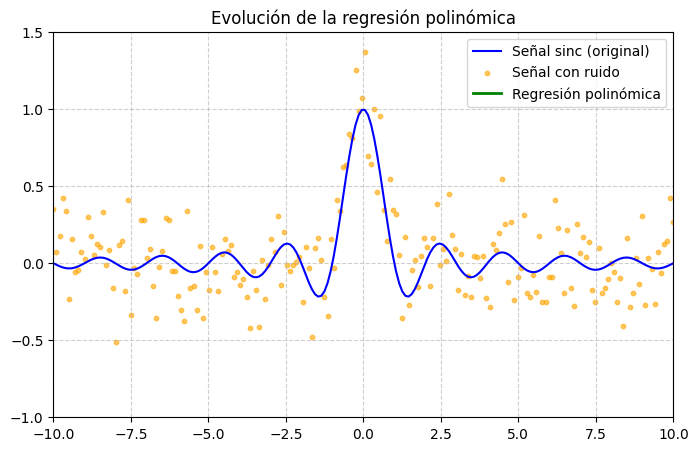

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# ====== Datos ======
t = np.linspace(-10, 10, 200)
signal = np.sinc(t)               # señal sinc original
np.random.seed(0)
ruido = 0.2 * np.random.randn(len(t))
signal_ruido = signal + ruido     # señal con ruido

# ====== Modelo polinómico ======
def poly_regression(degree, X, y):
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree)),
        ("lin", LinearRegression())
    ])
    model.fit(X[:, None], y)
    y_pred = model.predict(X[:, None])
    return y_pred

# ====== Figura ======
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlim(-10,10)
ax.set_ylim(-1,1.5)
ax.set_title("Evolución de la regresión polinómica")
ax.grid(True, linestyle="--", alpha=0.6)

# Señales
ax.plot(t, signal, label="Señal sinc (original)", color="blue")
ax.scatter(t, signal_ruido, label="Señal con ruido", color="orange", s=10, alpha=0.6)

# Curva de regresión que se irá actualizando
(line_reg,) = ax.plot([], [], color="green", lw=2, label="Regresión polinómica")
text_degree = ax.text(0.05, 0.9, "", transform=ax.transAxes)

ax.legend()

# ====== Inicializar ======
def init():
    line_reg.set_data([], [])
    text_degree.set_text("")
    return line_reg, text_degree

# ====== Actualizar en cada frame ======
def update(degree):
    y_pred = poly_regression(degree, t, signal_ruido)
    line_reg.set_data(t, y_pred)
    text_degree.set_text(f"Grado = {degree}")
    return line_reg, text_degree

# ====== Animación ======
anim = animation.FuncAnimation(
    fig, update, frames=range(1, 30),  # grados 1 a 14
    init_func=init, blit=False, interval=1000
)

HTML(anim.to_jshtml())


In [6]:
# === Celda B1 ===
# Definiciones adaptadas desde tu cuaderno: var_snr, my_2Dpdf, my_linregsyn, my_posterior_update, my_predictiva_update
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit


# my_2Dpdf (corregida: no mezclar xlim/ylim)
def my_2Dpdf(mu, Sigma, axes, N=100, h=0.02, xlabel_='$w_0$', ylabel_='$w_1$',
             cmap='Reds', xlim=None, ylim=None):
    pdfx = mn(mu, Sigma)
    # prepare meshgrid
    if xlim is None:
        x_min, x_max = pdfx.mean[0] - 4*np.sqrt(pdfx.cov[0,0]), pdfx.mean[0] + 4*np.sqrt(pdfx.cov[0,0])
    else:
        x_min, x_max = xlim[0], xlim[1]
    if ylim is None:
        y_min, y_max = pdfx.mean[1] - 4*np.sqrt(pdfx.cov[1,1]), pdfx.mean[1] + 4*np.sqrt(pdfx.cov[1,1])
    else:
        y_min, y_max = ylim[0], ylim[1]
    Xg = np.linspace(x_min, x_max, round(0.5*N))
    Yg = np.linspace(y_min, y_max, round(0.5*N))
    Xmesh, Ymesh = np.meshgrid(Xg, Yg)
    pos = np.empty(Xmesh.shape + (2,))
    pos[:, :, 0] = Xmesh
    pos[:, :, 1] = Ymesh
    Z = pdfx.pdf(pos)
    axes.contourf(Xmesh, Ymesh, Z, levels=20, cmap=cmap)
    axes.set_xlabel(xlabel_)
    axes.set_ylabel(ylabel_)
    axes.set_xlim(x_min, x_max)
    axes.set_ylim(y_min, y_max)
    return

def my_linregsyn(mu, Sigma, axes, xmin=-1, xmax=1, Nmod=10, xlim=[-1.2,1.2], ylim=[-1.2,1.2]):
    pdfw = mn(mu, Sigma)
    wmod = pdfw.rvs(size=Nmod)
    Xs = np.linspace(xmin, xmax, 200)
    for k in range(wmod.shape[0]):
        # for a weight vector [w0,w1] produce w0 + w1*x
        axes.plot(Xs, wmod[k,0] + wmod[k,1]*Xs, 'b', alpha=0.4)
    axes.set_xlabel('$x$')
    axes.set_ylabel('$f(x|w)$')
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    return

def my_posterior_update(X, t, sig_eta, sig_w, tol=1e-10):
    # X: design matrix (N x Q) (already including bias column)
    lambdaR = sig_eta / sig_w
    SNinv = X.T.dot(X) + lambdaR * np.eye(X.shape[1])
    val, vec = np.linalg.eigh(SNinv)
    ind = val > tol
    SN = vec[:, ind].dot(np.diag(1/val[ind])).dot(vec[:, ind].T)
    mN = np.squeeze(SN.dot(X.T.dot(t)))
    return mN, SN

def my_predictiva_update(xnew, mN, SN, sig_eta):
    # xnew: design matrix for new points (Nnew x Q)
    mnew = xnew.dot(mN)
    signew = np.diag(sig_eta * np.eye(xnew.shape[0]) + xnew.dot(SN).dot(xnew.T))
    return mnew, signew


#Punto 2 - Housing Dataset - cross validation

In [17]:
# ==============================================
# Step 1: Import libraries
# ==============================================
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from ipywidgets import interact, IntSlider, Dropdown

# ==============================================
# Step 2: Load dataset
# ==============================================
housing = fetch_california_housing()
X = housing.data
y = housing.target
feature_names = housing.feature_names

print("Available features:", feature_names)

# ==============================================
# Step 3: Function for polynomial regression demo
# ==============================================
def plot_polynomial_regression(feature="MedInc", degree=1):
    # Get column index for chosen feature
    idx = feature_names.index(feature)
    X_feature = X[:, idx].reshape(-1, 1)

    # Create polynomial regression pipeline
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("scaler", StandardScaler()),
        ("linreg", LinearRegression())
    ])

    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = cross_val_score(model, X_feature, y, cv=kf,
                                 scoring="neg_mean_squared_error")
    avg_mse = -np.mean(mse_scores)

    # Fit model on all data
    model.fit(X_feature, y)

    # Predict on a smooth range for plotting
    X_plot = np.linspace(X_feature.min(), X_feature.max(), 500).reshape(-1, 1)
    y_pred = model.predict(X_plot)

    # Plot
    plt.figure(figsize=(8,5))
    plt.scatter(X_feature, y, alpha=0.2, label="Data")
    plt.plot(X_plot, y_pred, color="red", linewidth=2, label=f"Degree {degree}")
    plt.xlabel(feature)
    plt.ylabel("Target (House Price)")
    plt.title(f"Polynomial Regression on {feature} vs Price")
    plt.legend()
    plt.show()

    # Print MSE info
    print(f"Cross-Validation MSE (5-fold): {avg_mse:.4f}")

# ==============================================
# Step 4: Interactive widget
# ==============================================
interact(
    plot_polynomial_regression,
    feature=Dropdown(options=feature_names, value="MedInc", description="Feature:"),
    degree=IntSlider(min=1, max=10, step=1, value=1, description="Degree:")
)


Available features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


interactive(children=(Dropdown(description='Feature:', options=('MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',…

<function __main__.plot_polynomial_regression(feature='MedInc', degree=1)>

In [21]:
# ==============================================
# Step 1: Import libraries
# ==============================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from ipywidgets import interact, Dropdown, IntSlider

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# ==============================================
# Step 2: Load dataset
# ==============================================
housing = fetch_california_housing()
X = housing.data
y = housing.target
feature_names = housing.feature_names

print("Available features:", feature_names)

# ==============================================
# Step 3: Function to animate regression
# ==============================================
def animate_polynomial_regression(feature="MedInc", max_degree=8):
    # Pick the feature
    idx = feature_names.index(feature)
    X_feature = X[:, idx].reshape(-1, 1)

    # Prepare points for smooth plotting
    X_plot = np.linspace(X_feature.min(), X_feature.max(), 500).reshape(-1, 1)

    # Create figure
    fig, ax = plt.subplots(figsize=(8,5))
    ax.scatter(X_feature, y, alpha=0.2, label="Data")
    line, = ax.plot([], [], color="red", linewidth=2)

    ax.set_xlim(X_feature.min(), X_feature.max())
    ax.set_ylim(y.min(), y.max())
    ax.set_xlabel(feature)
    ax.set_ylabel("House Price")
    ax.set_title(f"Polynomial Regression Animation for {feature}")

    # Animation function
    def update(degree):
        model = Pipeline([
            ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
            ("scaler", StandardScaler()),
            ("linreg", LinearRegression())
        ])
        model.fit(X_feature, y)
        y_pred = model.predict(X_plot)
        line.set_data(X_plot.ravel(), y_pred)
        ax.set_title(f"{feature} - Polynomial Degree {degree}")
        return line,

    ani = FuncAnimation(fig, update, frames=range(1, max_degree+1),
                        interval=1000, blit=True, repeat=False)

    plt.close(fig)  # Prevent duplicate static plot
    return HTML(ani.to_jshtml())

# ==============================================
# Step 4: Interactive selector
# ==============================================
interact(
    animate_polynomial_regression,
    feature=Dropdown(options=feature_names, value="MedInc", description="Feature:"),
    max_degree=IntSlider(min=3, max=12, step=1, value=8, description="Max Degree:")
)


Available features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


interactive(children=(Dropdown(description='Feature:', options=('MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',…

<function __main__.animate_polynomial_regression(feature='MedInc', max_degree=8)>